In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

In [2]:
from Networks import *


C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\ten

In [3]:
from Utility import *
import Logger

In [4]:
from matplotlib import pyplot as plt

In [7]:
dataFolder = r'Z:\2021_03_01_RandomlyDeformedGridMesh\Data128'
outputFolder = r'Z:\2021_03_01_RandomlyDeformedGridMesh\Training128_AllMarkers'
numMarkers = 50

numTest = 200

In [6]:
imgsPerMarker, uvsPerMarker = loadDataV1(dataFolder, numMarkers, )
trainData, trainUV, testData, testUV, numData = divideTrainValSetAll(imgsPerMarker, uvsPerMarker, numTest, shuffle=True)

numTrain = numData - numTest
print('trainData: ', trainData.shape)
print('trainUV: ', trainUV.shape)
print('testData: ', testData.shape)
print('testUV: ', testUV.shape)

trainData:  (39948, 128, 128, 3)
trainUV:  (39948, 128, 128, 2)
testData:  (10000, 128, 128, 3)
testUV:  (10000, 128, 128, 2)


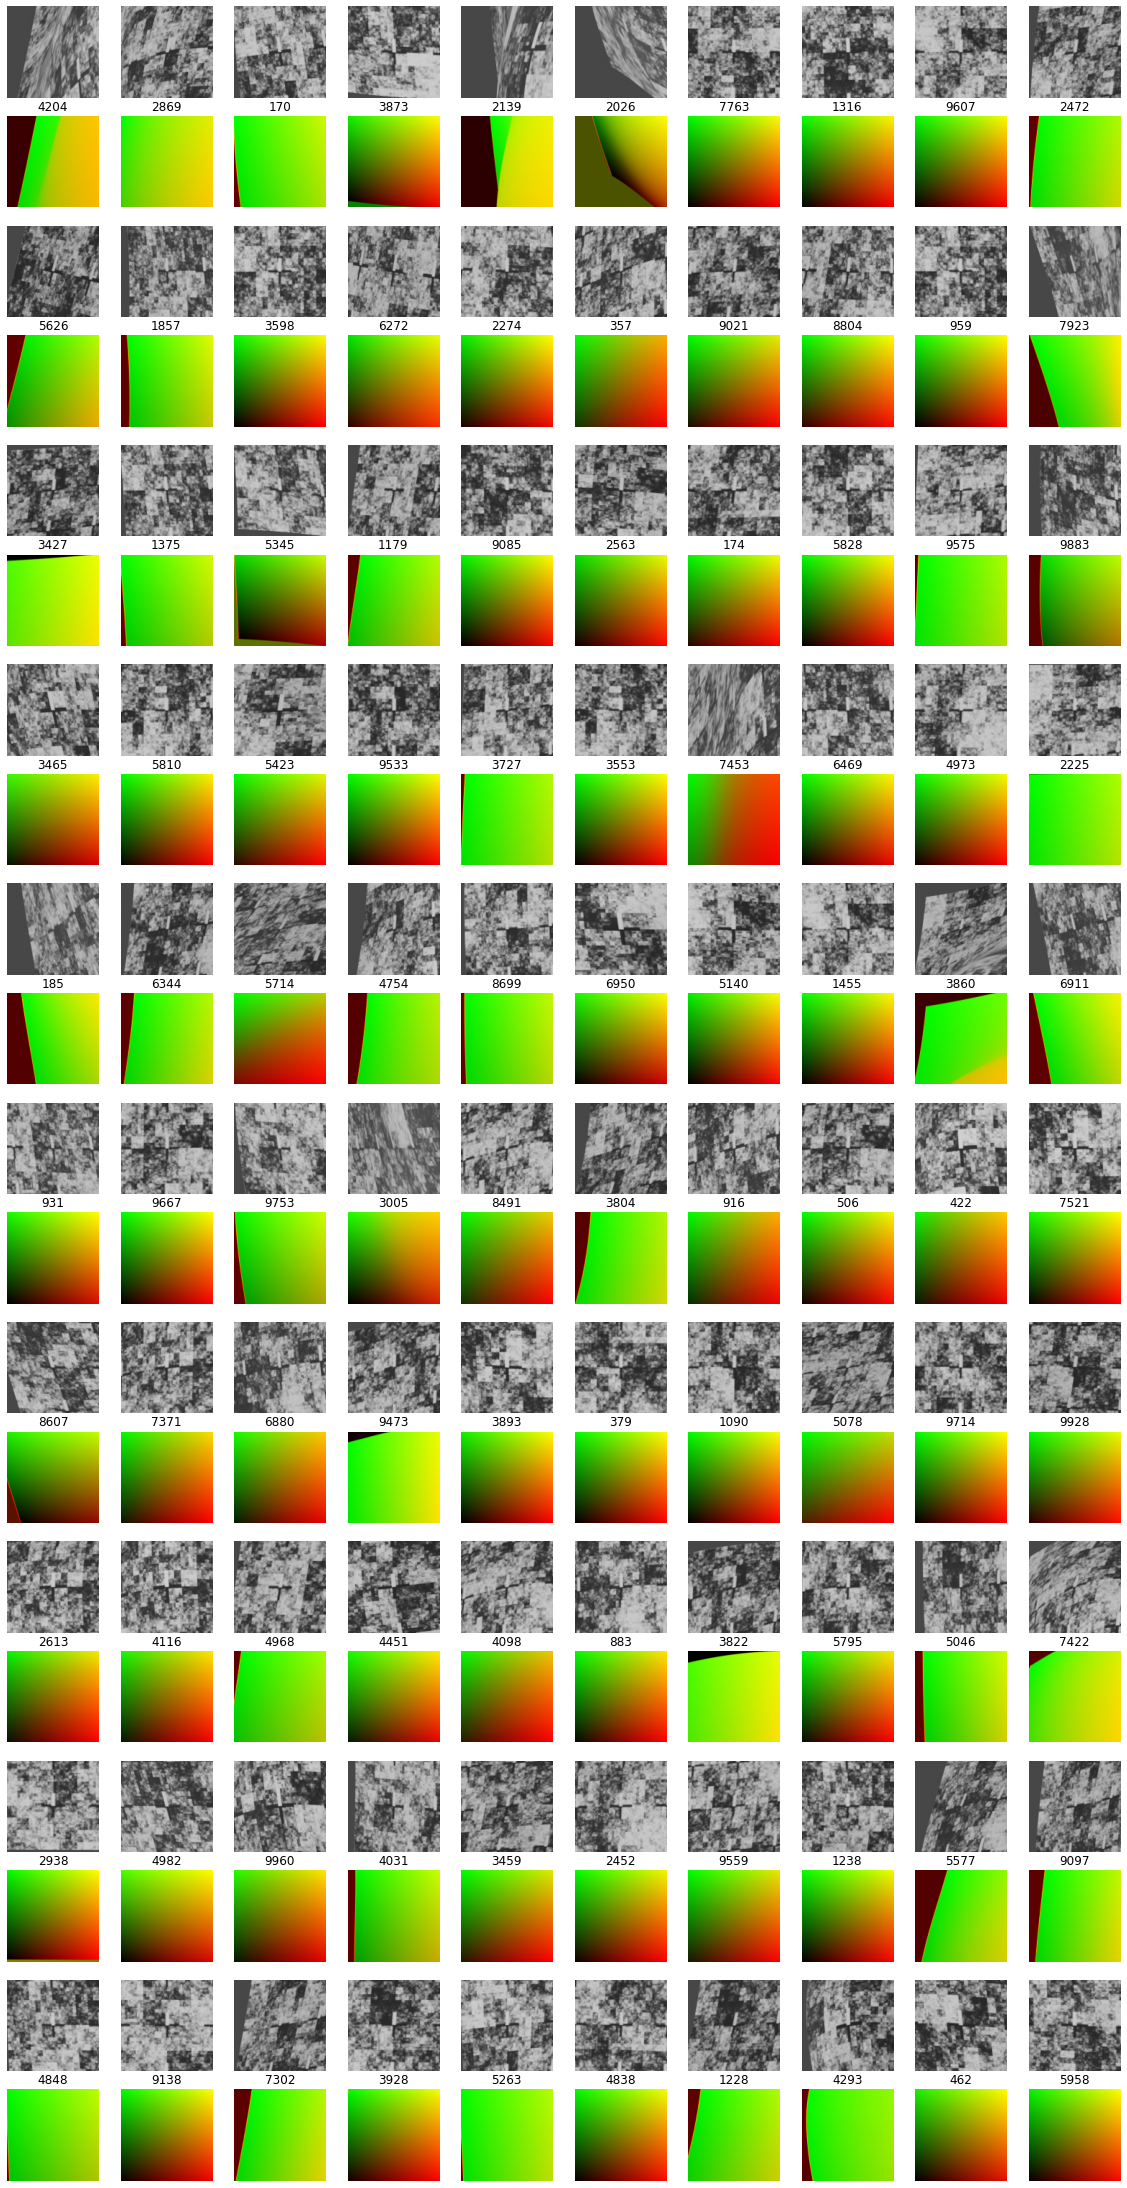

In [8]:
gridH = 20
gridW = 10
fig, axs = plt.subplots(gridH, gridW)


fig.set_size_inches(20, 20*(gridH/gridW))
for i, iMarker in enumerate(range(int(gridH/2))):
    imgIds = np.random.randint(0, len(testData), size=(gridW,))
    for j, iImg in enumerate(imgIds):
        axs[i*2, j].imshow(testData[iImg, ...], cmap="gray")
        axs[i*2, j].axis('off')
    
        axs[i*2+1, j].imshow(predToRGB(testUV[iImg, ...], normalize=True))
        axs[i*2+1, j].set_title("%d" % ( iImg))
        axs[i*2+1, j].axis('off')
        

In [9]:
# evaluation(testDa uvExtractor = UVExtractor('resnet_101', training=False,  pre_trained_model=r'C:\Code\MyRepo\00_DeepLearning\DeepLab-V3\data\models\pretrained\resnet_101\resnet_v2_101.ckpt')
uvExtractor = UVExtractor('resnet_50', training=True, inputShape=[None,128,128,3], labelShape=[None, 128,128,2])

In [10]:
fd = {uvExtractor.inputs:trainData[:10, :,:,:],
      uvExtractor.is_training:False,
      uvExtractor.target_width:128,
      uvExtractor.target_height:128,
      uvExtractor.labels:trainUV[:10, ...]
     }
featureMap = uvExtractor.sess.run(uvExtractor.outputs, feed_dict=fd)
print(featureMap.shape)

(10, 32, 32, 2)


In [11]:


errInfo={
    'Train':[],
    'Validation':[]

}

In [12]:
saver = tf.train.Saver()

os.makedirs(outputFolder, exist_ok=True)
logFile = join(outputFolder, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [13]:
bestValErr = 10000

In [14]:
sizeTrain = len(trainData)
numEpoch = 10000
batchSize = 32
weight_decay = 5e-4
lr = 1e-4
saveStep = 500
iEpoch = 0
plotStep = 10

numBatch = int(np.ceil(sizeTrain / batchSize))

cfg = Config()

cfg.lrDecayStep = numBatch * 10
cfg.lrDecayRate = 0.8

uvExtractor.cfg = cfg


In [ ]:

while iEpoch < numEpoch:
    for iBatch in range(numBatch):
        fd = {uvExtractor.inputs:trainData[iBatch*batchSize:(iBatch+1)*batchSize, :,:,:],
              uvExtractor.is_training:True,
              uvExtractor.target_width:128,
              uvExtractor.target_height:128,
              uvExtractor.labels:trainUV[iBatch*batchSize:(iBatch+1)*batchSize, ...],
              uvExtractor.weight_decay: weight_decay,
              uvExtractor.learning_rate: lr,
              uvExtractor.lrDecayRate_ph: cfg.lrDecayRate,
              uvExtractor.lrDecayStep_ph: cfg.lrDecayStep,
             }
        _ = uvExtractor.sess.run(uvExtractor.optimizer, feed_dict=fd)

    
    evalTrain = evaluate(trainData, trainUV, uvExtractor, batchSize=batchSize, perImgEval=False)    
    evalTest = evaluate(testData, testUV, uvExtractor, batchSize=batchSize, perImgEval=False)    
    errInfo['Train'].append(evalTrain)
    errInfo['Validation'].append(evalTest)
    
    if not iEpoch % saveStep:
        save_path = saver.save(uvExtractor.sess, join(outputFolder, "N03_UVExtractor_128_"+str(iEpoch).zfill(6)+".ckpt"))
        print("Saved check point to: ", save_path)
        
    infoStr = f'mean train err: %8.8g, max train err: %8.8g, mean val err: %8.8g, max val err:  %8.8g, learning rate: %8.8g, Epoch: %d' \
        % (evalTrain['MeanErr'], evalTrain['MaxErr'], evalTest['MeanErr'],  evalTest['MaxErr'], uvExtractor.sess.run(uvExtractor.learning_rate_decayed, feed_dict=fd), iEpoch)
    
    logger.info(infoStr)
    
    if bestValErr > evalTest['MeanErr']:
        bestValErr = evalTest['MeanErr']
        save_path = saver.save(uvExtractor.sess, join(outputFolder, "N08_UVExtractor_128_AllMarkers_best.ckpt"))
        print("Saved new best net's check point to: ", save_path)
        
        
    if iEpoch % plotStep == 0 and i:
#         print(infoStr)
        fig, a_loss = plt.subplots()

        
        json.dump(errInfo, open(join(outputFolder, 'Errors.json'), 'w'))
        
        trainMeanErrs = [err['MeanErr'] for err in  errInfo['Train']]
        valMeanErrs = [err['MeanErr'] for err in errInfo['Validation']]
        plt.close('all')
        X = list(range(len(trainMeanErrs)))
        a_loss.plot(X, trainMeanErrs, label = "mean training error")
        a_loss.plot(X, valMeanErrs, label = "mean validation error")
        
        a_loss.set_xlabel('iteration')
        # Set the y axis label of the current axis.
        a_loss.set_ylabel('mean localiztion error')
        a_loss.grid()
        a_loss.legend()
        fig.savefig(join(outputFolder,
                         'ErrCurve.png'),
                    dpi=256, transparent=False, bbox_inches='tight', )
        # to do: code to save the network weight with best validation results
        
    iEpoch += 1

Saved check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128_AllMarkers\N03_UVExtractor_128_000000.ckpt
2021-03-23 17:01:05,897 logger INFO mean train err: 0.040773044, max train err: 1.9181981, mean val err: 0.041732005, max val err:  1.8889367, learning rate: 1.1480821e-05, Epoch: 0
Saved new best net's check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128_AllMarkers\N08_UVExtractor_128_AllMarkers_best.ckpt
mean train err: 0.040773044, max train err: 1.9181981, mean val err: 0.041732005, max val err:  1.8889367, learning rate: 1.1480821e-05, Epoch: 0
2021-03-23 17:28:10,992 logger INFO mean train err: 0.0056308149, max train err: 0.86282341, mean val err: 0.0062835303, max val err:  1.0344247, learning rate: 1.122747e-05, Epoch: 1
Saved new best net's check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128_AllMarkers\N08_UVExtractor_128_AllMarkers_best.ckpt
2021-03-23 17:55:15,753 logger INFO mean train err: 0.0047494666, max train err: 1.029586

2021-03-24 09:09:17,364 logger INFO mean train err: 0.0035302437, max train err: 0.78916377, mean val err: 0.0041006464, max val err:  1.0557384, learning rate: 5.1415827e-06, Epoch: 36
Saved new best net's check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128_AllMarkers\N08_UVExtractor_128_AllMarkers_best.ckpt
2021-03-24 09:36:20,441 logger INFO mean train err: 0.0040311216, max train err: 0.77437547, mean val err: 0.0046020169, max val err:  1.0250206, learning rate: 5.0281237e-06, Epoch: 37
2021-03-24 10:03:10,888 logger INFO mean train err: 0.004253785, max train err: 0.79246065, mean val err: 0.0047653851, max val err:  1.0201794, learning rate: 4.9171663e-06, Epoch: 38
2021-03-24 10:29:59,177 logger INFO mean train err: 0.0050498294, max train err: 3.1432178, mean val err: 0.0055001226, max val err:  3.0274671, learning rate: 4.8086576e-06, Epoch: 39
2021-03-24 10:56:48,998 logger INFO mean train err: 0.0045808963, max train err: 1.9213591, mean val err: 0.005093710

2021-03-25 02:37:32,247 logger INFO mean train err: 0.0031820442, max train err: 0.69791376, mean val err: 0.0037009837, max val err:  0.985659, learning rate: 2.1535145e-06, Epoch: 75
2021-03-25 03:04:25,074 logger INFO mean train err: 0.0036950552, max train err: 0.69823438, mean val err: 0.0042044444, max val err:  1.0301794, learning rate: 2.1059932e-06, Epoch: 76
2021-03-25 03:31:15,998 logger INFO mean train err: 0.0034367543, max train err: 0.6989553, mean val err: 0.0039606558, max val err:  1.026923, learning rate: 2.0595194e-06, Epoch: 77
2021-03-25 03:58:05,934 logger INFO mean train err: 0.0045696967, max train err: 1.9053434, mean val err: 0.005078873, max val err:  1.8178195, learning rate: 2.0140715e-06, Epoch: 78
2021-03-25 04:24:57,477 logger INFO mean train err: 0.0042211551, max train err: 0.69478051, mean val err: 0.0047522138, max val err:  0.99530808, learning rate: 1.9696263e-06, Epoch: 79
2021-03-25 04:51:49,452 logger INFO mean train err: 0.0054572296, max trai

2021-03-25 20:59:24,193 logger INFO mean train err: 0.0052687999, max train err: 3.5362935, mean val err: 0.005770551, max val err:  3.5410096, learning rate: 8.6261485e-07, Epoch: 116
2021-03-25 21:26:17,634 logger INFO mean train err: 0.0044115727, max train err: 0.6955688, mean val err: 0.004892819, max val err:  0.9853665, learning rate: 8.4357919e-07, Epoch: 117
2021-03-25 21:53:12,408 logger INFO mean train err: 0.003122168, max train err: 0.69954166, mean val err: 0.00364839, max val err:  0.98055186, learning rate: 8.2496365e-07, Epoch: 118
2021-03-25 22:20:06,048 logger INFO mean train err: 0.0031475768, max train err: 0.69981699, mean val err: 0.0036811791, max val err:  1.0035129, learning rate: 8.0675892e-07, Epoch: 119
2021-03-25 22:47:02,049 logger INFO mean train err: 0.0031873905, max train err: 0.69871978, mean val err: 0.0037466829, max val err:  0.99416327, learning rate: 7.889559e-07, Epoch: 120
mean train err: 0.0031873905, max train err: 0.69871978, mean val err: 

In [29]:
save_path = saver.save(uvExtractor.sess, join(outputFolder, "N03_UVExtractor_128_best.ckpt"))

TypeError: Cannot interpret feed_dict key as Tensor: The name 'save_2/Const:0' refers to a Tensor which does not exist. The operation, 'save_2/Const', does not exist in the graph.

In [15]:
# read best trained checkpoint
loadWeights = True
saveName = "N03_UVExtractor_128_best.ckpt"
if loadWeights:
    saver = tf.train.Saver()
    saver.restore(uvExtractor.sess, join(r'Z:\2021_03_01_RandomlyDeformedGridMesh\Training128', saveName))
else:
    init = tf.global_variables_initializer()
    sess.run(init)

INFO:tensorflow:Restoring parameters from Z:\2021_03_01_RandomlyDeformedGridMesh\Training128\N03_UVExtractor_128_best.ckpt


In [ ]:
evaluation(testData, testUV, uvExtractor)